In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
from datetime import timedelta
from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import seaborn as sns

import networkx as nx
import pickle

In [2]:
# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/MalgunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)
rc('font', family='Malgun Gothic')

In [3]:
# 데이터를 불러옵니다.
# data = pd.read_csv('data/antidepressant_prescription_all_years.csv', encoding='utf-8')
data = pd.read_parquet('data/antidepressant_prescription_all_years.parquet')

ad_mapping = pd.read_csv('data/antidepressant_mapping_v2.csv', encoding='utf-8')

In [4]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data.shape)
data.head()

(1183768, 16)


기준년도  가입자일련번호  처방내역일련번호  일련번호  성별코드  연령대코드(5세단위)  시도코드     요양개시일자  \
0  2017       31  47455974     2     2           10    26 2017-03-23   
1  2017       56  36005918     2     2           11    30 2017-11-13   
2  2017       62   7819529     2     1           12    41 2017-07-11   
3  2017       62  35429246     2     1           12    41 2017-08-08   
4  2017       62  37765102     5     1           12    41 2017-06-09   

   약품일반성분명코드  1회 투약량  1일투약량  총투여일수     단가     금액   데이터 공개일자    ATC코드  
0  229601ATB     1.0      2     35  152.0  10640 2018-11-26  N06AX14  
1  229601ATB     1.0      3     14  158.0   6636 2018-11-26  N06AX14  
2  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05  
3  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05  
4  242901ATB     2.0      1     28   40.0   2240 2018-11-26  N06AX05

In [5]:
# 처방내역일련번호로 그룹화하여 처방된 약품의 개수를 세어봅니다.
pd.DataFrame(data.groupby('처방내역일련번호')['약품일반성분명코드'].count().value_counts()).T

약품일반성분명코드      1       2      3     4    5   6   7   8   9   12
count      836681  127866  23766  3978  706  87   8   2   1   1

### 약품일반성분명코드란?
**약품일반성분명코드** 또는 **주성분코드**는 의약품의 대표하는 성분에 대한 코드입니다. \
총 9자리로 구성되어 있으며 구성은 아래와 같습니다. 앞 4자리의 주성분 일련번호가 동일하면 동일한 성분으로 생각할 수 있습니다.

![주성분코드](img/주성분코드.png)

이후로는 Main Ingredient Code (MI_code)라고 지칭하도록 하겠습니다.

In [6]:
# 컬럼 이름들을 영문으로 바꿔줍니다
df = data.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'user_id',
    '처방내역일련번호': 'pres_id',
    '일련번호': 'med_id',
    '성별코드': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '시도코드': 'region',
    '요양개시일자': 'start_date',
    '약품일반성분명코드': 'mi_code',
    '1회 투약량': 'dose_per_time',
    '1일투약량': 'dose_per_day',
    '총투여일수': 'total_days',
    '단가': 'unit_price',
    '금액': 'total_price',
    '데이터 공개일자': 'data_release_date',
    'ATC코드': 'ATC_code'
})

In [7]:
# 한 환자당 처방전의 개수를 세어봅니다.
df.groupby('user_id')['pres_id'].count().describe()

count    219817.000000
mean          5.385243
std           7.321897
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         161.000000
Name: pres_id, dtype: float64

한 사람당 여러번의 처방전이 발부될 수 있고, 그 처방전들 중 같은 약을 포함하기도하고 다른 약을 포함하기도 한다는 것을 볼 수 있습니다.

두 종류의 약물이 같이 처방된 빈도 수를 계산할 때, 같은 사람에게 여러번 처방된 케이스는 같이 처방된 횟수로 나누어야 한다고 판단했습니다.

그렇지 않으면 한사람에게 여러번 처방된 약들이 weight에 불평등한 영향을 미칠 것으로 예상됩니다.

In [8]:
# 약물별 처방 완료 기간 컬럼을 추가합니다
df['end_date'] = df['start_date'] + pd.to_timedelta(df['total_days'], unit='D')

# 처방 완료 기간이 2022년 이후인 경우 2021년 12월 31일로 변경합니다
df['end_date_past_2022'] = df['end_date'] >= pd.Timestamp('2022-01-01')
df.loc[df['end_date_past_2022'], 'end_date'] = pd.Timestamp('2021-12-31', unit='D')
df.drop(columns=['end_date_past_2022'], inplace=True)
                                              

In [9]:
# 각 연도별 그래프를 생성하는 함수를 만듭니다.
def create_yearly_graph(data):
    yearly_graphs = {}
    
    # 연도별로 데이터를 그룹화합니다.
    for year, group in data.groupby('year'):
        G = nx.Graph()
        
        # 노드를 추가합니다.
        for atc_code in group['ATC_code'].unique():
            G.add_node(atc_code)

        # user_id와 pres_id로 그룹화하여 동시 발생을 찾습니다.
        user_cooccurrences = {}
        for user_id, user_group in group.groupby('user_id'):
            # 각 user_id에 대해 co-occurrence를 집합으로 저장합니다.
            cooccurrences = set()
            for pres_id, pres_group in user_group.groupby('pres_id'):
                atc_codes = pres_group['ATC_code'].unique()
                for i in range(len(atc_codes)):
                    for j in range(i + 1, len(atc_codes)):
                        cooccurrence = tuple(sorted((atc_codes[i], atc_codes[j])))
                        cooccurrences.add(cooccurrence)
            user_cooccurrences[user_id] = cooccurrences

        # co-occurrence를 그래프에 추가합니다.
        for cooccurrences in user_cooccurrences.values():
            for atc_code1, atc_code2 in cooccurrences:
                if G.has_edge(atc_code1, atc_code2):
                    G[atc_code1][atc_code2]['weight'] += 1
                else:
                    G.add_edge(atc_code1, atc_code2, weight=1)
                
        yearly_graphs[year] = G
    
    return yearly_graphs

## 그래프 시각화
이제 NetworkX를 통해 시각화를 해주도록 하겠습니다.

In [10]:
# ATC 코드를 약품명으로 바꿔줍니다.
atc_to_name = ad_mapping.set_index('ATC_code')['ATC_name'].to_dict()

# 노드를 인덱스로 변환합니다 (색상을 입히기 위함)
encode_node = {node: idx for idx, node in enumerate(df['ATC_code'].unique())}

def draw_graph(G, year, layout):
    # 그래프를 그립니다.
    plt.figure(figsize=(10, 8))
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)

    # 노드의 색상을 주성분 이름에 따라 설정합니다.
    node_color_by_abbrev = [encode_node[node] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

    # 엣지의 투명도를 weight에 비례하게 설정합니다.
    max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
    for edge in G.edges(data="weight"):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

    # 인덱스를 이용한 노드 레이블링을 합니다.
    labels = {node: atc_to_name[node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(f'{year}년도 처방 데이터 네트워크')
    
    return plt

In [ ]:
# 연도별 그래프를 생성합니다.
yearly_graphs = create_yearly_graph(df)

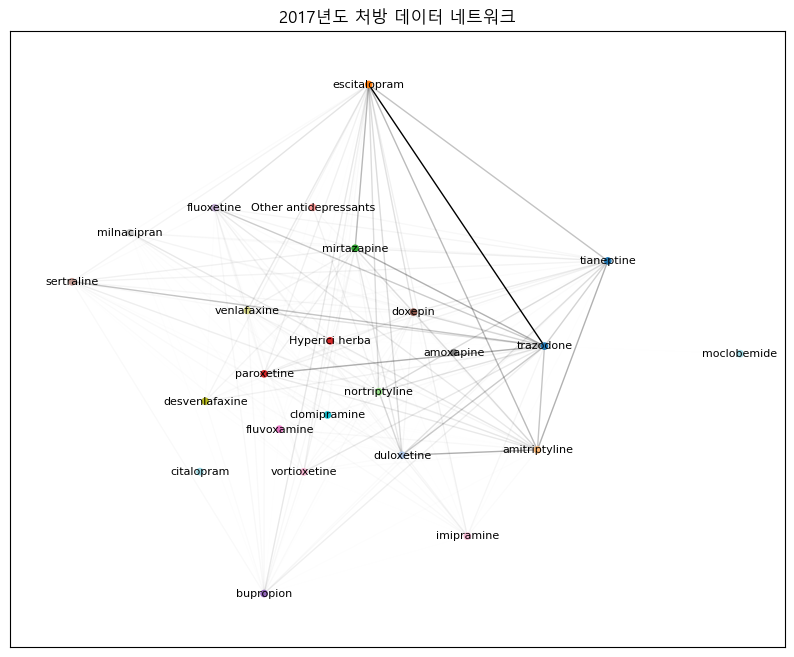

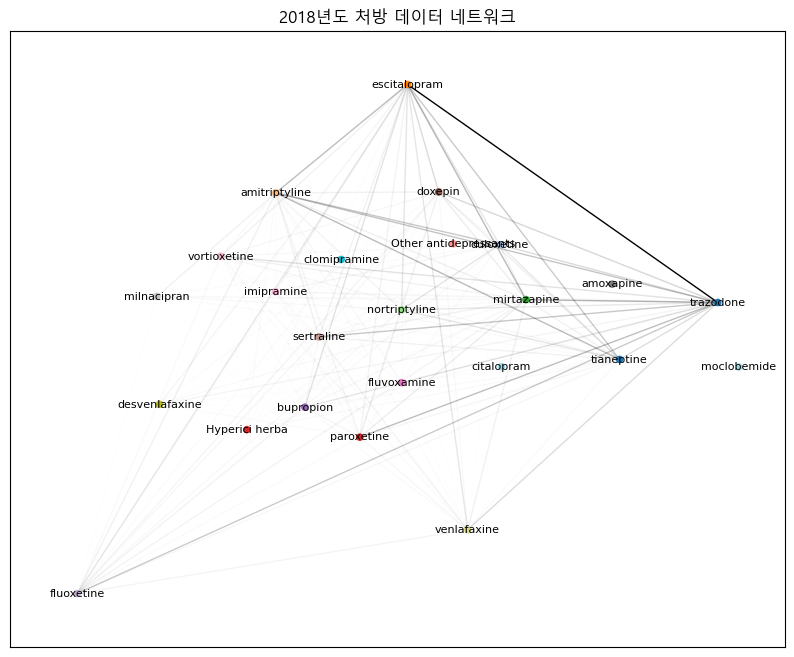

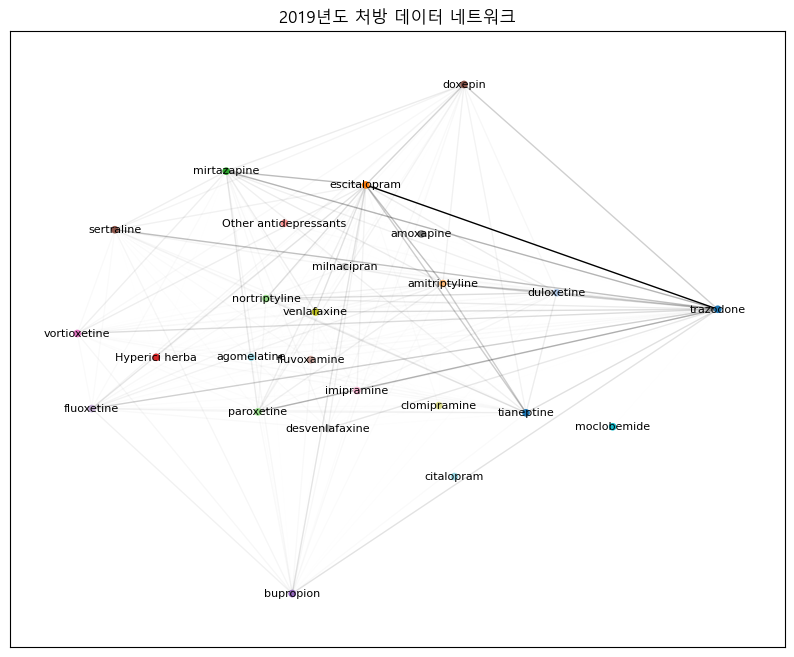

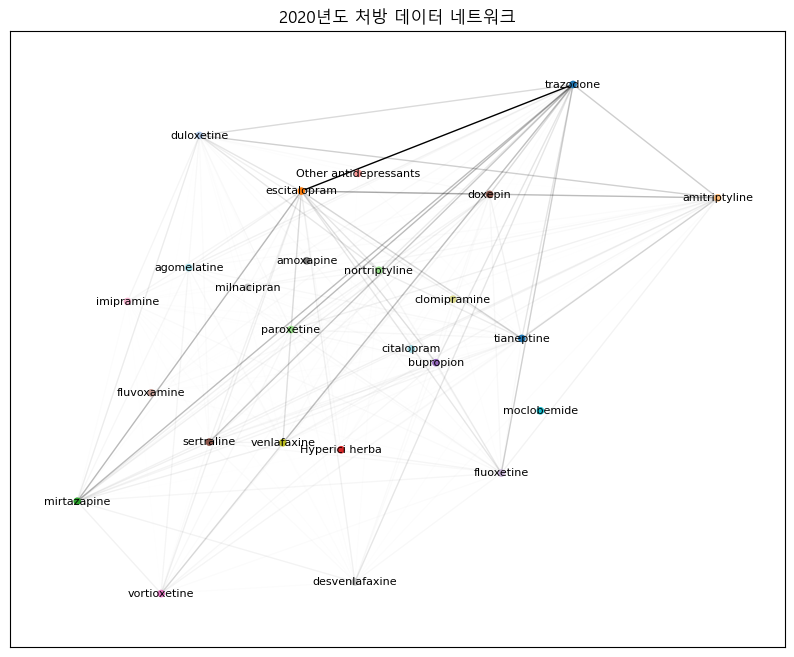

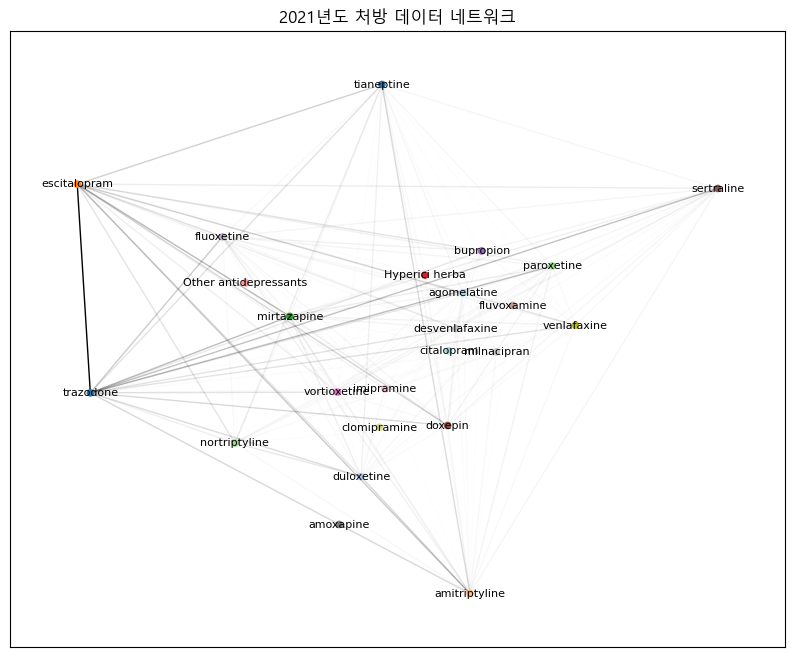

In [15]:
# 2017~2021년까지의 그래프를 서브플롯으로 그립니다.
for idx, year in enumerate(range(2017, 2022)):
    G = yearly_graphs[year]
    # 각 networkx 그래프를 파일로 저장합니다
    pickle.dump(G, open('data/networkx/{year}_antidepressant_network.pickle', 'wb'))

    draw_graph(G, year, 'kamada_kawai')
plt.show()

In [16]:
# Calculate network density for each year
for year in range(2017, 2022):
    G = yearly_graphs[year]
    density = nx.density(G)
    print(f'{year}년도 네트워크 밀도: {density:.4f}')
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    print(f'노드 수: {n_nodes}, 엣지 수: {n_edges}')

2017년도 네트워크 밀도: 0.6848
노드 수: 24, 엣지 수: 189
2018년도 네트워크 밀도: 0.6957
노드 수: 24, 엣지 수: 192
2019년도 네트워크 밀도: 0.7100
노드 수: 25, 엣지 수: 213
2020년도 네트워크 밀도: 0.6933
노드 수: 25, 엣지 수: 208
2021년도 네트워크 밀도: 0.7681
노드 수: 24, 엣지 수: 212


In [17]:
# Gephi 파일로 추출합니다
for year, G in yearly_graphs.items():
    nx.write_gexf(G, f'data/gephi/antidepressant_prescription_{year}.gexf')

---
---

## 다이나믹 시각화 (Gephi 사용)

In [ ]:
# 각 약품이 처방된 첫 날짜와 마지막 날짜를 찾습니다
first_appearance = df.groupby('ATC_code')['start_date'].min()
last_appearance = df.groupby('ATC_code')['end_date'].max()

# 시작 날짜와 마지막 날짜를 합칩니다
appearance = pd.concat([first_appearance, last_appearance], axis=1)
appearance.columns = ['first_appearance', 'last_appearance']
appearance

first_appearance last_appearance
ATC_code                                 
N06AA02        2017-01-02      2021-12-31
N06AA04        2017-01-02      2021-12-31
N06AA09        2017-01-02      2021-12-31
N06AA10        2017-01-02      2021-12-31
N06AA12        2017-01-02      2021-12-31
N06AA17        2017-01-03      2021-12-31
N06AB03        2017-01-02      2021-12-31
N06AB04        2017-01-06      2021-03-15
N06AB05        2017-01-02      2021-12-31
N06AB06        2017-01-02      2021-12-31
N06AB08        2017-01-02      2021-12-31
N06AB10        2017-01-02      2021-12-31
N06AG02        2017-01-06      2020-10-02
N06AX          2017-01-02      2021-12-31
N06AX05        2017-01-02      2021-12-31
N06AX11        2017-01-02      2021-12-31
N06AX12        2017-01-02      2021-12-31
N06AX14        2017-01-01      2021-12-31
N06AX16        2017-01-02      2021-12-31
N06AX17        2017-01-02      2021-12-31
N06AX21        2017-01-01      2021-12-31
N06AX22        2019-05-09      2021-12-31
N06AX23        2017-01-02      2021-12-31
N06AX25        2017-01-02      2021-12-31
N06AX26        2017-01-02      2021-12-31

In [48]:
ad_mapping[ad_mapping['ATC_code'].isin(['N06AX22', 'N06AG02'])]

MI_code ATC_code     ATC_name
49  613101ATB  N06AX22  agomelatine
70  196701ATB  N06AG02  moclobemide

#### 특이사항
- N06AX22인 agomelatine이 2019년도에 새로 처방받기 시작한 노드인 것을 볼 수 있습니다.
- N06AG02인 moclobemide은 2021년도에 처방 기록이 없습니다.


In [53]:
df.head()

year  user_id   pres_id  med_id  gender  age_group  region start_date  \
0  2017       31  47455974       2       2         10      26 2017-03-23   
1  2017       56  36005918       2       2         11      30 2017-11-13   
2  2017       62   7819529       2       1         12      41 2017-07-11   
3  2017       62  35429246       2       1         12      41 2017-08-08   
4  2017       62  37765102       5       1         12      41 2017-06-09   

     mi_code  dose_per_time  dose_per_day  total_days  unit_price  \
0  229601ATB            1.0             2          35       152.0   
1  229601ATB            1.0             3          14       158.0   
2  242901ATB            2.0             1          28        40.0   
3  242901ATB            2.0             1          28        40.0   
4  242901ATB            2.0             1          28        40.0   

   total_price data_release_date ATC_code   end_date  
0        10640        2018-11-26  N06AX14 2017-04-27  
1         6636        2018-11-26  N06AX14 2017-11-27  
2         2240        2018-11-26  N06AX05 2017-08-08  
3         2240        2018-11-26  N06AX05 2017-09-05  
4         2240        2018-11-26  N06AX05 2017-07-07

In [49]:
# Node 파일 생성을 위한 데이터프레임 생성
node_df = pd.DataFrame()
node_df['id'] = df['ATC_code'].unique()
node_df['label'] = node_df['id'].map(atc_to_name)
node_df['start_date'] = pd.to_datetime(node_df['id'].map(first_appearance))
node_df['start_date'] = node_df['start_date'].dt.strftime('%Y-%m-%d')
node_df['end_date'] = pd.to_datetime(node_df['id'].map(last_appearance))
node_df['end_date'] = node_df['end_date']

# Gephi에서 사용할 Node 파일 생성
node_df.to_csv('data/gephi/ad_prescription_nodes.csv', index=False)

In [63]:
node_df.head()

id          label  start_date   end_date
0  N06AX14     tianeptine  2017-01-01 2021-12-31
1  N06AX05      trazodone  2017-01-02 2021-12-31
2  N06AX21     duloxetine  2017-01-01 2021-12-31
3  N06AB10   escitalopram  2017-01-02 2021-12-31
4  N06AA09  amitriptyline  2017-01-02 2021-12-31

In [56]:
# Create a dictionary to store the counts of co-prescriptions per day
co_prescription_counts = {}

# Group by user_id to process each patient's prescriptions
for user_id, user_group in df.groupby('user_id'):
    # For each prescription, find the co-prescriptions
    for pres_id, pres_group in user_group.groupby('pres_id'):
        atc_codes = pres_group['ATC_code'].unique()
        start_date = pres_group['start_date'].min()
        end_date = pres_group['end_date'].max()
        
        # Iterate over the date range of the prescription
        current_date = start_date
        while current_date <= end_date:
            for i in range(len(atc_codes)):
                for j in range(i + 1, len(atc_codes)):
                    atc_pair = tuple(sorted((atc_codes[i], atc_codes[j])))
                    if atc_pair not in co_prescription_counts:
                        co_prescription_counts[atc_pair] = {}
                    if current_date not in co_prescription_counts[atc_pair]:
                        co_prescription_counts[atc_pair][current_date] = 0
                    co_prescription_counts[atc_pair][current_date] += 1
            current_date += timedelta(days=1)

In [69]:
co_prescription_counts.keys()

dict_keys([('N06AB05', 'N06AB10'), ('N06AA12', 'N06AX05'), ('N06AA12', 'N06AB06'), ('N06AB06', 'N06AX05'), ('N06AA09', 'N06AB08'), ('N06AB06', 'N06AB10'), ('N06AB10', 'N06AX17'), ('N06AB10', 'N06AX05'), ('N06AA09', 'N06AX11'), ('N06AA12', 'N06AX14'), ('N06AA12', 'N06AB10'), ('N06AB10', 'N06AX14'), ('N06AX12', 'N06AX17'), ('N06AA09', 'N06AB10'), ('N06AB05', 'N06AX05'), ('N06AB10', 'N06AX22'), ('N06AB10', 'N06AX21'), ('N06AA09', 'N06AX21'), ('N06AB05', 'N06AX11'), ('N06AA09', 'N06AX05'), ('N06AB10', 'N06AX23'), ('N06AA09', 'N06AX14'), ('N06AA12', 'N06AX11'), ('N06AB10', 'N06AX12'), ('N06AA10', 'N06AB03'), ('N06AX05', 'N06AX21'), ('N06AA10', 'N06AX21'), ('N06AA09', 'N06AX12'), ('N06AB05', 'N06AX12'), ('N06AX05', 'N06AX12'), ('N06AA09', 'N06AB05'), ('N06AB10', 'N06AX11'), ('N06AB06', 'N06AX11'), ('N06AX11', 'N06AX26'), ('N06AA10', 'N06AX05'), ('N06AB03', 'N06AX05'), ('N06AB05', 'N06AB06'), ('N06AB10', 'N06AX25'), ('N06AA12', 'N06AB05'), ('N06AA09', 'N06AB06'), ('N06AA02', 'N06AB10'), ('N06

In [72]:
co_prescription_counts[('N06AB05', 'N06AB10')]

{Timestamp('2019-07-30 00:00:00'): 18,
 Timestamp('2019-07-31 00:00:00'): 16,
 Timestamp('2019-08-01 00:00:00'): 14,
 Timestamp('2019-08-02 00:00:00'): 16,
 Timestamp('2019-08-03 00:00:00'): 16,
 Timestamp('2019-08-04 00:00:00'): 16,
 Timestamp('2019-08-05 00:00:00'): 18,
 Timestamp('2019-08-06 00:00:00'): 19,
 Timestamp('2019-08-07 00:00:00'): 19,
 Timestamp('2019-08-08 00:00:00'): 18,
 Timestamp('2019-08-09 00:00:00'): 18,
 Timestamp('2019-08-10 00:00:00'): 19,
 Timestamp('2019-08-11 00:00:00'): 19,
 Timestamp('2019-08-12 00:00:00'): 19,
 Timestamp('2019-08-13 00:00:00'): 20,
 Timestamp('2019-06-18 00:00:00'): 18,
 Timestamp('2019-06-19 00:00:00'): 19,
 Timestamp('2019-06-20 00:00:00'): 20,
 Timestamp('2019-06-21 00:00:00'): 22,
 Timestamp('2019-06-22 00:00:00'): 23,
 Timestamp('2019-06-23 00:00:00'): 22,
 Timestamp('2019-06-24 00:00:00'): 22,
 Timestamp('2019-06-25 00:00:00'): 22,
 Timestamp('2019-06-26 00:00:00'): 21,
 Timestamp('2019-06-27 00:00:00'): 20,
 Timestamp('2019-06-28 00

In [79]:
for atc_pair, date_counts in co_prescription_counts.items():
    print(atc_pair)
    print(sorted(date_counts.items()))
    break

('N06AB05', 'N06AB10')
[(Timestamp('2017-01-06 00:00:00'), 2), (Timestamp('2017-01-07 00:00:00'), 3), (Timestamp('2017-01-08 00:00:00'), 3), (Timestamp('2017-01-09 00:00:00'), 4), (Timestamp('2017-01-10 00:00:00'), 4), (Timestamp('2017-01-11 00:00:00'), 5), (Timestamp('2017-01-12 00:00:00'), 5), (Timestamp('2017-01-13 00:00:00'), 5), (Timestamp('2017-01-14 00:00:00'), 5), (Timestamp('2017-01-15 00:00:00'), 5), (Timestamp('2017-01-16 00:00:00'), 5), (Timestamp('2017-01-17 00:00:00'), 6), (Timestamp('2017-01-18 00:00:00'), 6), (Timestamp('2017-01-19 00:00:00'), 8), (Timestamp('2017-01-20 00:00:00'), 8), (Timestamp('2017-01-21 00:00:00'), 8), (Timestamp('2017-01-22 00:00:00'), 8), (Timestamp('2017-01-23 00:00:00'), 9), (Timestamp('2017-01-24 00:00:00'), 9), (Timestamp('2017-01-25 00:00:00'), 9), (Timestamp('2017-01-26 00:00:00'), 9), (Timestamp('2017-01-27 00:00:00'), 9), (Timestamp('2017-01-28 00:00:00'), 9), (Timestamp('2017-01-29 00:00:00'), 9), (Timestamp('2017-01-30 00:00:00'), 9), (

In [107]:
# Add edges with dynamic weights
for atc_pair, date_counts in co_prescription_counts.items():
    for i, (date, count) in enumerate(sorted(date_counts.items())):
        print(atc_pair, date.strftime('%Y-%m-%d'), count, i)
        if i > 1:
            break

('N06AB05', 'N06AB10') 2017-01-06 2 0
('N06AB05', 'N06AB10') 2017-01-07 3 1
('N06AB05', 'N06AB10') 2017-01-08 3 2
('N06AA12', 'N06AX05') 2017-01-05 2 0
('N06AA12', 'N06AX05') 2017-01-06 2 1
('N06AA12', 'N06AX05') 2017-01-07 3 2
('N06AA12', 'N06AB06') 2017-01-06 1 0
('N06AA12', 'N06AB06') 2017-01-07 2 1
('N06AA12', 'N06AB06') 2017-01-08 2 2
('N06AB06', 'N06AX05') 2017-01-02 2 0
('N06AB06', 'N06AX05') 2017-01-03 4 1
('N06AB06', 'N06AX05') 2017-01-04 4 2
('N06AA09', 'N06AB08') 2017-01-10 1 0
('N06AA09', 'N06AB08') 2017-01-11 1 1
('N06AA09', 'N06AB08') 2017-01-12 2 2
('N06AB06', 'N06AB10') 2017-01-03 1 0
('N06AB06', 'N06AB10') 2017-01-04 2 1
('N06AB06', 'N06AB10') 2017-01-05 2 2
('N06AB10', 'N06AX17') 2017-01-03 1 0
('N06AB10', 'N06AX17') 2017-01-04 1 1
('N06AB10', 'N06AX17') 2017-01-05 1 2
('N06AB10', 'N06AX05') 2017-01-02 9 0
('N06AB10', 'N06AX05') 2017-01-03 15 1
('N06AB10', 'N06AX05') 2017-01-04 25 2
('N06AA09', 'N06AX11') 2017-01-02 2 0
('N06AA09', 'N06AX11') 2017-01-03 3 1
('N06AA09'

In [ ]:
# Create a dynamic graph
G = nx.Graph()

# Add nodes
for row in node_df.itertuples():
    G.add_node(row.id, label=row.label, start_date=str(row.start_date), end_date=str(row.end_date))

# Add edges with dynamic weights
for atc_pair, date_counts in co_prescription_counts.items():
    for i, (date, count) in enumerate(sorted(date_counts.items())):
        G.add_edge(u_of_edge=atc_pair[0], 
                   v_of_edge=atc_pair[1], 
                   label=f"{atc_pair[0]}_{atc_pair[1]}_{i}",
                   timestamp=date.strftime('%Y-%m-%d'),
                   weight=count
        )
        G.add_weighted_edges_from([(atc_pair[0], atc_pair[1], count)])

# Export the graph to a GEXF file
output_file = 'data/gephi/antidepressant_prescription_dynamic.gexf'
# save as version 1.3 to support dynamic graphs
nx.write_gexf(G, output_file, version='1.2draft')
print(f'Gephi file saved to {output_file}')

Gephi file saved to data/gephi/antidepressant_prescription_dynamic.gexf


In [ ]:
# New way:

# 1. Create a dataframe that has all the possible medicine pair in its rows and all days in its columns
# 2. If a patient is prescribed both medicines in a pair, increment the corresponding day by 1
# 3. Create a gefx file for all the years using the dataframe 
# 3a. The weight of the edge between two medicines is the value of the cell in the dataframe for that pair and day

# Part 1:
# Create a dataframe that has all the possible medicine pair in its rows and all days in its columns
# Get all the unique ATC codes
unique_codes = data['ATC_code'].unique()

# Create a dataframe with all the possible pairs
pairs = list(combinations(unique_codes, 2))
pair_df = pd.DataFrame(pairs, columns=['ATC_code1', 'ATC_code2'])

# Create a dataframe with all the possible pairs and days
pair_df = pd.DataFrame(pairs, columns=['ATC_code1', 'ATC_code2'])

# date goes from 2017-01-01 to 2021-12-31
date_range = pd.date_range(start='2017-01-01', end='2021-12-31')
date_range = date_range.strftime('%Y-%m-%d')    
pair_df = pd.concat([pair_df, pd.DataFrame(columns=date_range)], axis=1)
pair_df

ATC_code1 ATC_code2 2017-01-01 2017-01-02 2017-01-03 2017-01-04  \
0     N06AX14   N06AX05        NaN        NaN        NaN        NaN   
1     N06AX14   N06AX21        NaN        NaN        NaN        NaN   
2     N06AX14   N06AB10        NaN        NaN        NaN        NaN   
3     N06AX14   N06AA09        NaN        NaN        NaN        NaN   
4     N06AX14   N06AX11        NaN        NaN        NaN        NaN   
..        ...       ...        ...        ...        ...        ...   
295   N06AA04   N06AB04        NaN        NaN        NaN        NaN   
296   N06AA04   N06AX22        NaN        NaN        NaN        NaN   
297   N06AG02   N06AB04        NaN        NaN        NaN        NaN   
298   N06AG02   N06AX22        NaN        NaN        NaN        NaN   
299   N06AB04   N06AX22        NaN        NaN        NaN        NaN   

    2017-01-05 2017-01-06 2017-01-07 2017-01-08  ... 2021-12-22 2021-12-23  \
0          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1          NaN        NaN        NaN        NaN  ...        NaN        NaN   
2          NaN        NaN        NaN        NaN  ...        NaN        NaN   
3          NaN        NaN        NaN        NaN  ...        NaN        NaN   
4          NaN        NaN        NaN        NaN  ...        NaN        NaN   
..         ...        ...        ...        ...  ...        ...        ...   
295        NaN        NaN        NaN        NaN  ...        NaN        NaN   
296        NaN        NaN        NaN        NaN  ...        NaN        NaN   
297        NaN        NaN        NaN        NaN  ...        NaN        NaN   
298        NaN        NaN        NaN        NaN  ...        NaN        NaN   
299        NaN        NaN        NaN        NaN  ...        NaN        NaN   

    2021-12-24 2021-12-25 2021-12-26 2021-12-27 2021-12-28 2021-12-29  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1          NaN        NaN        NaN        NaN        NaN        NaN   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
295        NaN        NaN        NaN        NaN        NaN        NaN   
296        NaN        NaN        NaN        NaN        NaN        NaN   
297        NaN        NaN        NaN        NaN        NaN        NaN   
298        NaN        NaN        NaN        NaN        NaN        NaN   
299        NaN        NaN        NaN        NaN        NaN        NaN   

    2021-12-30 2021-12-31  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN  
..         ...        ...  
295        NaN        NaN  
296        NaN        NaN  
297        NaN        NaN  
298        NaN        NaN  
299        NaN        NaN  

[300 rows x 1828 columns]

In [ ]:
pair_df.loc[:, '2019-06-18']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
295    NaN
296    NaN
297    NaN
298    NaN
299    NaN
Name: 2019-06-18, Length: 300, dtype: object

In [ ]:
# Part 2:
# If a patient is prescribed both medicines in a pair, increment the corresponding day by 1

# Create a dictionary to store the counts
pair_counts = {}

# Group by user_id and pres_id
for user_id, user_group in data.groupby('user_id'):
    for pres_id, pres_group in user_group.groupby('pres_id'):
        atc_codes = pres_group['ATC_code'].unique()
        if len(atc_codes) > 1:
            start_date = pres_group['treatment_start_date'].min()
            end_date = min(pd.to_datetime(start_date) + pd.Timedelta(days=pres_group['total_days'].max()), pd.to_datetime('2021-12-31'))
            date_range = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d')
            
            for atc_code1, atc_code2 in combinations(atc_codes, 2):
                pair = tuple(sorted((atc_code1, atc_code2)))
                if pair not in pair_counts:
                    pair_counts[pair] = {date: 0 for date in date_range}
                for date in date_range:
                    if date not in pair_counts[pair]:
                        pair_counts[pair][date] = 0
                    pair_counts[pair][date] += 1

KeyError: 'index'

In [26]:
pair_counts

{('N06AB05', 'N06AB10'): {'2019-07-30': 18,
  '2019-07-31': 16,
  '2019-08-01': 14,
  '2019-08-02': 16,
  '2019-08-03': 16,
  '2019-08-04': 16,
  '2019-08-05': 18,
  '2019-08-06': 19,
  '2019-08-07': 19,
  '2019-08-08': 18,
  '2019-08-09': 18,
  '2019-08-10': 19,
  '2019-08-11': 19,
  '2019-08-12': 19,
  '2019-08-13': 20,
  '2019-06-18': 18,
  '2019-06-19': 19,
  '2019-06-20': 20,
  '2019-06-21': 22,
  '2019-06-22': 23,
  '2019-06-23': 22,
  '2019-06-24': 22,
  '2019-06-25': 22,
  '2019-06-26': 21,
  '2019-06-27': 20,
  '2019-06-28': 21,
  '2019-06-29': 21,
  '2019-06-30': 21,
  '2019-07-01': 22,
  '2019-07-02': 23,
  '2019-07-03': 25,
  '2019-07-04': 23,
  '2019-07-05': 22,
  '2019-07-06': 22,
  '2019-07-07': 22,
  '2019-07-08': 22,
  '2019-07-09': 23,
  '2019-04-23': 20,
  '2019-04-24': 17,
  '2019-04-25': 18,
  '2019-04-26': 17,
  '2019-04-27': 17,
  '2019-04-28': 17,
  '2019-04-29': 17,
  '2019-04-30': 19,
  '2019-05-01': 18,
  '2019-05-02': 18,
  '2019-05-03': 19,
  '2019-05-04': 

In [40]:
# Convert the dictionary to a DataFrame
pair_df = pd.DataFrame.from_dict(pair_counts, orient='index').reset_index()
# pair_df[['ATC_code1', 'ATC_code2']] = pd.DataFrame(pair_df['index'].tolist(), index=pair_df.index)
# pair_df.drop(columns=['index'], inplace=True)
pair_df.rename(columns={'level_0': 'ATC_code1', 'level_1': 'ATC_code2'}, inplace=True)

# Sort columns by date
pair_df = pair_df.reindex(sorted(pair_df.columns), axis=1)

# Replace NaN with 0
pair_df.fillna(0, inplace=True)

In [42]:
pair_df

2017-01-02  2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  \
0           0.0         0.0         0.0         0.0         2.0         3.0   
1           0.0         0.0         0.0         2.0         2.0         3.0   
2           0.0         0.0         0.0         0.0         1.0         2.0   
3           2.0         4.0         4.0         7.0         8.0        10.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
232         0.0         0.0         0.0         0.0         0.0         0.0   
233         0.0         0.0         0.0         0.0         0.0         0.0   
234         0.0         0.0         0.0         0.0         0.0         0.0   
235         0.0         0.0         0.0         0.0         0.0         0.0   
236         0.0         0.0         0.0         0.0         0.0         0.0   

     2017-01-08  2017-01-09  2017-01-10  2017-01-11  ...  2021-12-24  \
0           3.0         4.0         4.0         5.0  ...        19.0   
1           3.0         3.0         4.0         4.0  ...        92.0   
2           2.0         3.0         3.0         3.0  ...        20.0   
3          10.0        13.0        20.0        23.0  ...       142.0   
4           0.0         0.0         1.0         1.0  ...         6.0   
..          ...         ...         ...         ...  ...         ...   
232         0.0         0.0         0.0         0.0  ...         0.0   
233         0.0         0.0         0.0         0.0  ...         0.0   
234         0.0         0.0         0.0         0.0  ...         0.0   
235         0.0         0.0         0.0         0.0  ...         0.0   
236         0.0         0.0         0.0         0.0  ...         0.0   

     2021-12-25  2021-12-26  2021-12-27  2021-12-28  2021-12-29  2021-12-30  \
0          19.0        19.0        19.0        19.0        18.0        18.0   
1          90.0        90.0        94.0        95.0        94.0        91.0   
2          20.0        20.0        20.0        22.0        21.0        21.0   
3         134.0       132.0       139.0       143.0       142.0       146.0   
4           6.0         6.0         6.0         6.0         6.0         6.0   
..          ...         ...         ...         ...         ...         ...   
232         0.0         0.0         0.0         0.0         0.0         0.0   
233         0.0         0.0         0.0         0.0         0.0         0.0   
234         0.0         0.0         0.0         0.0         0.0         0.0   
235         0.0         0.0         0.0         0.0         0.0         0.0   
236         0.0         0.0         0.0         0.0         0.0         0.0   

     2021-12-31  ATC_code1  ATC_code2  
0          19.0    N06AB05    N06AB10  
1          90.0    N06AA12    N06AX05  
2          21.0    N06AA12    N06AB06  
3         142.0    N06AB06    N06AX05  
4           5.0    N06AA09    N06AB08  
..          ...        ...        ...  
232         0.0    N06AB05      N06AX  
233         0.0    N06AA12    N06AA17  
234         0.0    N06AA17      N06AX  
235         0.0    N06AA04    N06AX14  
236         0.0    N06AB03    N06AG02  

[237 rows x 1827 columns]

In [ ]:
# Temporary save
pair_df.to_csv('data/gephi/pair_df.csv', index=False)

# Read
pair_df = pd.read_csv('data/gephi/pair_df.csv')

In [38]:
# Part 3:
# Create a gefx file for all the years using the dataframe
def create_dynamic_gexf(pair_df):
    G = nx.Graph()

    # Add all nodes
    for atc_code in pair_df['ATC_code1'].unique():
        G.add_node(atc_code, label=atc_to_name[atc_code], start="2017-01-01", end="2021-12-31")

    # Add all edges
    for idx, row in pair_df.iterrows():
        for date in date_range:
            if row[date] > 0:
                G.add_edge(row['ATC_code1'], row['ATC_code2'], 
                           interval=f'[{date}/{date}]',
                           weight=row[date])

    output_file = 'data/gephi/antidepressant_prescription_dynamic.gexf'
    nx.write_gexf(G, output_file)
    print(f'Gephi file saved to {output_file}')

    return G

G = create_dynamic_gexf(pair_df)

Gephi file saved to data/gephi/antidepressant_prescription_dynamic.gexf


In [44]:
def create_dynamic_gexf(pair_df):
    G = nx.Graph()

    # Add all nodes
    for atc_code in pd.concat([pair_df['ATC_code1'], pair_df['ATC_code2']]).unique():
        G.add_node(atc_code, label=atc_to_name.get(atc_code, atc_code), start="2017-01-01", end="2021-12-31")

    # Add all edges
    for idx, row in pair_df.iterrows():
        for date in row.index[:-2]:  # Skip the last two columns (ATC_code1 and ATC_code2)
            if row[date] > 0:
                if G.has_edge(row['ATC_code1'], row['ATC_code2']):
                    edge_data = G[row['ATC_code1']][row['ATC_code2']]
                    edge_data['interval'] += f',{date}/{date}'
                    edge_data['weights'].append((date, row[date]))
                else:
                    G.add_edge(row['ATC_code1'], row['ATC_code2'], 
                               interval=f'[{date}/{date}]',
                               weights=[(date, row[date])])

    # Adjust weights dynamically
    for u, v, data in G.edges(data=True):
        intervals = data['interval'].split(',')
        weights = data['weights']
        dynamic_weights = []
        current_weight = 0

        for interval, (date, weight) in zip(intervals, weights):
            current_weight += weight
            dynamic_weights.append((interval, current_weight))

        data['weight'] = dynamic_weights

    return G

G = create_dynamic_gexf(pair_df)

In [46]:
# Write to GEXF
output_file = 'data/gephi/antidepressant_prescription_dynamic.gexf'
nx.write_gexf(G, output_file)
print(f'Gephi file saved to {output_file}')

ValueError: not enough values to unpack (expected 3, got 2)

In [17]:
from datetime import timedelta

def create_dynamic_graph_with_weights(data):
    # 모든 날짜를 포함하는 네트워크 딕셔너리
    dynamic_graphs = {}

    # 데이터 전처리: 날짜 형식 변환
    data['start_date'] = pd.to_datetime(data['treatment_start_date'])
    data['end_date'] = data['start_date'] + pd.to_timedelta(data['total_days'], unit='D')

    # 연도별로 데이터를 그룹화
    for year, group in data.groupby('year'):
        G = nx.Graph()
        
        # 노드 추가
        for atc_code in group['ATC_code'].unique():
            G.add_node(atc_code)

        # Edge 업데이트를 위한 날짜별 가중치 변화 저장
        edge_changes = {}

        # 처방 데이터를 기반으로 날짜별 weight 변화 기록
        for user_id, user_group in group.groupby('user_id'):
            for pres_id, pres_group in user_group.groupby('pres_id'):
                atc_codes = pres_group['ATC_code'].unique()
                start_date = pres_group['start_date'].min()
                end_date = pres_group['end_date'].max()

                for i in range(len(atc_codes)):
                    for j in range(i + 1, len(atc_codes)):
                        atc_pair = tuple(sorted((atc_codes[i], atc_codes[j])))

                        # Edge가 존재하지 않으면 생성
                        if atc_pair not in edge_changes:
                            edge_changes[atc_pair] = {}

                        # 날짜별로 weight 업데이트
                        current_date = start_date
                        while current_date <= end_date:
                            if current_date not in edge_changes[atc_pair]:
                                edge_changes[atc_pair][current_date] = 0
                            edge_changes[atc_pair][current_date] += 1
                            current_date += timedelta(days=1)

        # 날짜별 네트워크 생성
        all_dates = set()
        for edge, changes in edge_changes.items():
            all_dates.update(changes.keys())

        for date in sorted(all_dates):
            if date not in dynamic_graphs:
                dynamic_graphs[date] = nx.Graph()

            for edge, changes in edge_changes.items():
                if date in changes:
                    weight = changes[date]

                    # 그래프에 Edge 추가 또는 업데이트
                    if dynamic_graphs[date].has_edge(*edge):
                        dynamic_graphs[date][edge[0]][edge[1]]['weight'] += weight
                    else:
                        dynamic_graphs[date].add_edge(edge[0], edge[1], weight=weight)

    return dynamic_graphs
